In [1]:
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import pycomlink as pycml

# Read instantaneous and min_max data
The min-max data was derived from the instantaneous example data set

In [3]:
cml_list = pycml.io.examples.get_75_cmls()
cml_list_min_max = pycml.io.examples.get_75_cmls_min_max()

75 CMLs read in
75 CMLs read in


# Plot both data types for a single CML

In [4]:
cml_index = 0 # select a single cml

print("CML metadata:")
ch1_pol = cml_list[cml_index].channel_1.metadata['polarization']
ch1_freq = cml_list[cml_index].channel_1.metadata['frequency'] / 1.0e9
print("Channel 1 - frequency: {} GHz, polarization: {}".format(ch1_freq, ch1_pol))

ch2_pol = cml_list[cml_index].channel_2.metadata['polarization']
ch2_freq = cml_list[cml_index].channel_2.metadata['frequency'] / 1.0e9
print("Channel 2 - frequency: {} GHz, polarization: {}".format(ch2_freq, ch2_pol))

CML metadata:
Channel 1 - frequency: 18.195 GHz, polarization: V
Channel 2 - frequency: 19.205 GHz, polarization: V


<IPython.core.display.Javascript object>


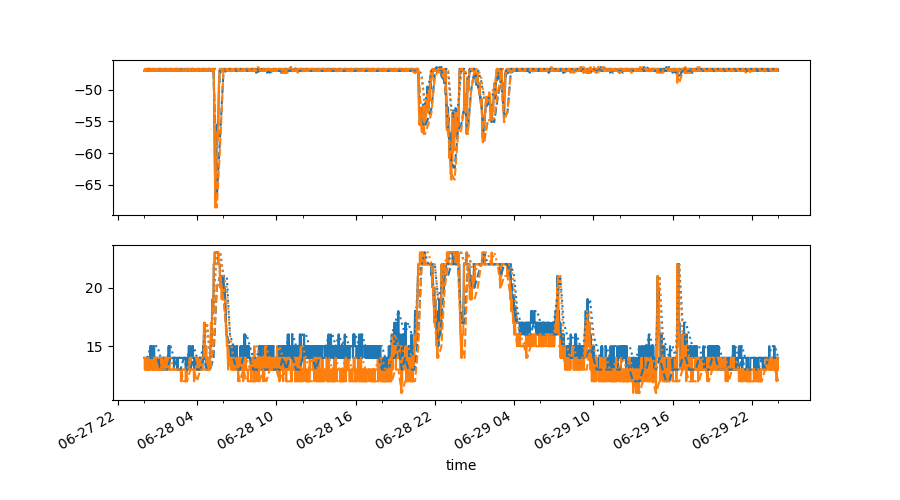

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(9, 5), sharex=True)
cml_list[cml_index].channel_1.data.rx.plot(ax=ax[0])
cml_list[cml_index].channel_2.data.rx.plot(ax=ax[0])
cml_list[cml_index].channel_1.data.tx.plot(ax=ax[1])
cml_list[cml_index].channel_2.data.tx.plot(ax=ax[1])
    
cml_list_min_max[cml_index].channel_1.data.rx_min.plot(ax=ax[0], color='C0', linestyle='--')
cml_list_min_max[cml_index].channel_2.data.rx_min.plot(ax=ax[0], color='C1', linestyle='--')
cml_list_min_max[cml_index].channel_1.data.rx_max.plot(ax=ax[0], color='C0', linestyle=':')
cml_list_min_max[cml_index].channel_2.data.rx_max.plot(ax=ax[0], color='C1', linestyle=':')

cml_list_min_max[cml_index].channel_1.data.tx_min.plot(ax=ax[1], color='C0', linestyle='--')
cml_list_min_max[cml_index].channel_2.data.tx_min.plot(ax=ax[1], color='C1', linestyle='--')
cml_list_min_max[cml_index].channel_1.data.tx_max.plot(ax=ax[1], color='C0', linestyle=':')
cml_list_min_max[cml_index].channel_2.data.tx_max.plot(ax=ax[1], color='C1', linestyle=':')

# Pre-processing for min-max algorithm
Pre-processing starts with calculating <b>A_diff</b>, which will later be used to estimate parameters of the min-max algorithm

<IPython.core.display.Javascript object>


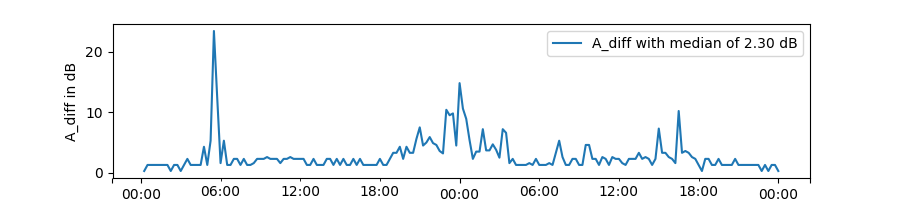

In [6]:
A_diff = (cml_list_min_max[cml_index].channel_1.tx_max - cml_list_min_max[cml_index].channel_1.tx_min) + \
        (cml_list_min_max[cml_index].channel_1.rx_max - cml_list_min_max[cml_index].channel_1.rx_min)
fig, ax = plt.subplots(1, 1, figsize=(9, 2), sharex=True)
A_diff.plot(ax=ax, label='A_diff with median of %.2f dB' % A_diff.median())
ax.set_ylabel('A_diff in dB')
ax.legend()

<b>gT</b> and <b>gR</b> are parameters of the min-max processing algorithm and are related to the dB quantization of the tx/rx levels and the microwave hardware.<br>
To estimate gT and gR we start by calculating <b>A_diff</b> using min-max tx and rx over a long time period with long dry periods (to avoid over-estimation of gT/gR).<br>
Next, we estimate <b>gT+gR</b> using the median value of A_diff (thus reducing the effect of large A_diff values caused by rain events).<br>
Finally, we assume that both gT and gR equal half the median of A_diff (only gT+gR is used by the algorithm).<br>
The function below implements the above procedure to estimate gT and gR.

In [7]:
def estimate_gT_gR(cml_min_max):
    ''' use the tx_max, tx_min, rx_max, rx_min time series of cml_min_max
    and calculate A_diff = (tx_max-tx_min)+(rx_max-rx_min) 
    use the median value of A_diff to estimate gT and gR.
    '''
    A_diff = (cml_min_max.channel_1.tx_max - cml_min_max.channel_1.tx_min) + \
            (cml_min_max.channel_1.rx_max - cml_min_max.channel_1.rx_min)
    gT = A_diff.median()/2.0
    gR = A_diff.median()/2.0
    return gT, gR

# Processing of both data types
Process both instantaneous and min-max data and calculate R

In [8]:
# process instantaneous rx and tx
inst_window = 30 # number of measurements for time window
inst_threshold = 1.0
cml_list[cml_index].process.wet_dry.std_dev(window_length=inst_window, threshold=inst_threshold)
cml_list[cml_index].process.baseline.linear()
cml_list[cml_index].process.baseline.calc_A()
cml_list[cml_index].process.A_R.calc_R()
    
# process min-max rx and tx
min_max_window = 7
k = 15 # because the min-max data was generated using 1 minute instantaneous data
gT, gR = 1.0, 0.6 # the default gT/gR values
cml_list_min_max[cml_index].process.baseline.calc_A_min_max(gT=gT, gR=gR, window=min_max_window)
_ = cml_list_min_max[cml_index].process.A_R.calc_R_min_max(k=k)

# Plot rain rates for both data types
Plot the results of processing both instantaneous and the min-max data

<IPython.core.display.Javascript object>


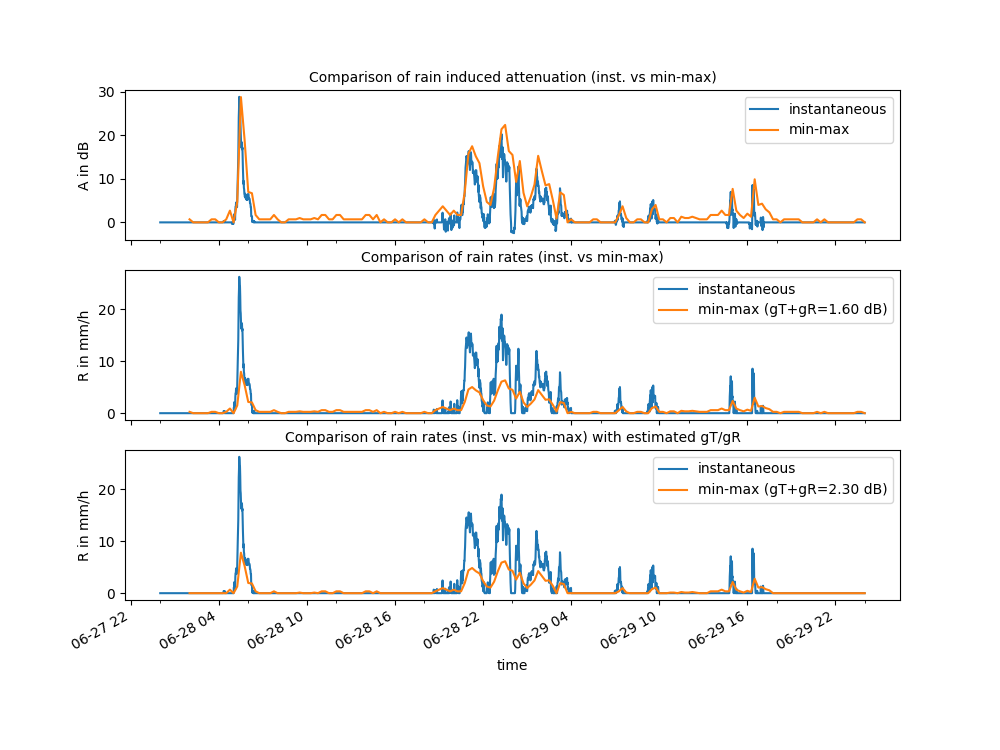

In [9]:
num_data_columns = 3
fig, ax = plt.subplots(num_data_columns, 1, figsize=(10, 1.5*num_data_columns + 3), sharex=True)

ax[0].set_title('Comparison of rain induced attenuation (inst. vs min-max)', fontsize=10)
ax[0].set_ylabel('A in dB')
cml_list[cml_index].channel_1.data.A.plot(ax=ax[0], label='instantaneous')
cml_list_min_max[cml_index].channel_1.data.Ar_max.plot(ax=ax[0], label='min-max')
ax[0].legend()

ax[1].set_title('Comparison of rain rates (inst. vs min-max)', fontsize=10)
ax[1].set_ylabel('R in mm/h')
cml_list[cml_index].channel_1.data.R.plot(ax=ax[1], label='instantaneous')
cml_list_min_max[cml_index].channel_1.data.R.plot(ax=ax[1], label='min-max (gT+gR=%.2f dB)' % (gT+gR))
ax[1].legend()

# try different values for gT and gR (using the  estimate_gT_gR function we previously defined)
est_gT, est_gR = estimate_gT_gR(cml_list_min_max[cml_index])
cml_list_min_max[cml_index].process.baseline.calc_A_min_max(gT=est_gT, gR=est_gR, window=min_max_window)
cml_list_min_max[cml_index].process.A_R.calc_R_min_max(k=k)

ax[2].set_title('Comparison of rain rates (inst. vs min-max) with estimated gT/gR', fontsize=10)
ax[2].set_ylabel('R in mm/h')
cml_list[cml_index].channel_1.data.R.plot(ax=ax[2], label='instantaneous')
cml_list_min_max[cml_index].channel_1.data.R.plot(ax=ax[2], label='min-max (gT+gR=%.2f dB)' % (est_gT+est_gR))
ax[2].legend()

# Plot cumulative rain for both data types
Compare cumulative rain for instantaneous and the min-max data

<IPython.core.display.Javascript object>


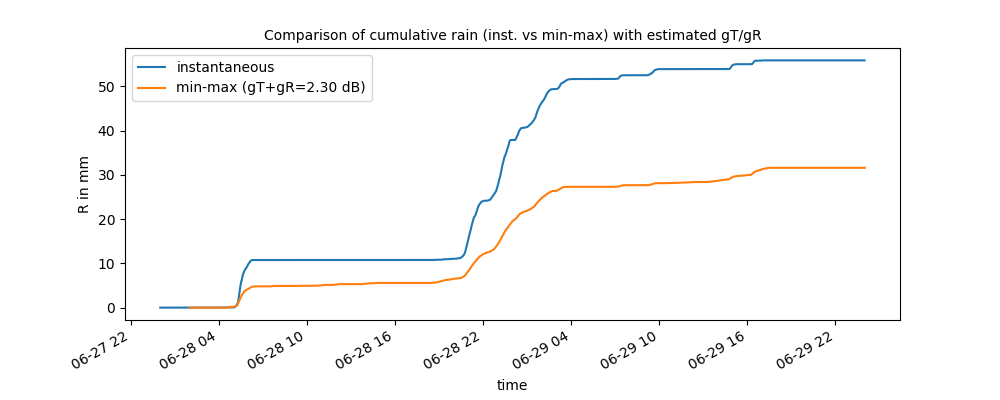

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4), sharex=True)
ax.set_title('Comparison of cumulative rain (inst. vs min-max) with estimated gT/gR', fontsize=10)
ax.set_ylabel('R in mm')
(cml_list[cml_index].channel_1.data.R.cumsum()/60.0).plot(ax=ax, label='instantaneous')
(cml_list_min_max[cml_index].channel_1.data.R.cumsum()/4.0).plot(ax=ax, label='min-max (gT+gR=%.2f dB)' % (est_gT+est_gR))
ax.legend()